In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from cdlib import algorithms, evaluation
import random

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'karateclub', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
random.seed(0)
np.random.seed(0)

In [3]:
def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 != 0) ) # volte in cui hanno votato la stessa  ed erano entrambi presenti
    diversi = np.sum((voti_dep1 != voti_dep2) & (voti_dep1 != 0) & (voti_dep2 != 0) ) # volte in cui hanno votato diversamente ed erano entrambi presenti
    
    if uguali == 0:
        sim = 0
    else:
        sim = uguali/(uguali+diversi)
    return sim

In [4]:
df = pd.read_csv('../data_collection/xviii-years/xviii-2022.csv')
df.shape

(616, 1618)

In [5]:
df.reset_index(inplace= True, drop = True)
indici = []
for i in range(df.shape[0]):
    if np.count_nonzero(df.iloc[i,4:]) < 0.3*(df.shape[1]-4):
        indici.append(i)


df.drop(indici, axis = 0, inplace = True)
df.reset_index(inplace= True, drop = True)
df.shape

(219, 1618)

Alignment and partisan discipline

In [6]:
#works only with dataframes like ours
def alignment_parties(df):
    col = df.columns[4:].to_list()
    col.append('Partito')
    parties_alignment = pd.DataFrame()
    party = df.groupby('Partito')
    for i in party: # party[0] nome partito, party[1] dataframe
        a = np.apply_along_axis(statistics.mode, axis = 0, arr= i[1])[4:].tolist()
        a.append(i[0])
        parties_alignment = pd.concat([parties_alignment, pd.DataFrame(a).T], axis = 0)

    parties_alignment.columns = col
    return parties_alignment


alignment = alignment_parties(df)
alignment

,634001,635018,635001,635023,635010,635020,635007,635013,635002,635021,...,737026,737018,737033,737016,737003,737031,737023,737052,737035,Partito
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-SI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,CI
0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,...,1.0,3.0,1.0,3.0,0.0,1.0,1.0,0.0,1.0,FDI
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,FI
0,1.0,3.0,0.0,3.0,1.0,1.0,1.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IPF-IC
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IV-IC'E'
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LEGA
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,3.0,M5S
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MISTO
0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,3.0,PD


In [7]:
discipline = []
for index, row in df.iterrows():
    p = alignment[alignment['Partito'] == row['Partito']]
    c = 0
    for i in p.drop('Partito', axis = 1).columns:
        if row[i] == np.float64(p[i][0]):
            c+=1
    
    discipline.append(c/(len(p.columns) - 1))

df['discipline'] = discipline

Graph

In [8]:
m = np.array(df[df.columns[4:df.shape[1]-1]])

A = np.zeros((len(m),len(m))) #inizializzo matrice a 0
i=0
j=0
for i in range(len(m)):
    for j in range(len(m)):
        A[i,j] = similarita(m[i],m[j])

In [9]:
G = nx.from_numpy_matrix(A)
G.remove_edges_from(nx.selfloop_edges(G))
threshold = np.percentile(A, q = 50)
G.remove_edges_from([(n1, n2) for n1, n2, w in G.edges(data="weight") if w < threshold])
print(G.number_of_edges())

11881


In [10]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

In [11]:
drop_weights(G)

add id as node label

In [12]:
val = {}
for i in G.nodes:
    val[i] = df['id'][i] 

In [13]:
nx.set_node_attributes(G, name = 'id', values = val)

## Community detection

In [14]:
from cdlib import NodeClustering

### Louvain

In [15]:
comm = algorithms.louvain(G)

In [16]:
cc = NodeClustering(comm.communities[:2], G)

In [17]:
cc.newman_girvan_modularity()

FitnessResult(min=None, max=None, score=0.21764601693840427, std=None)

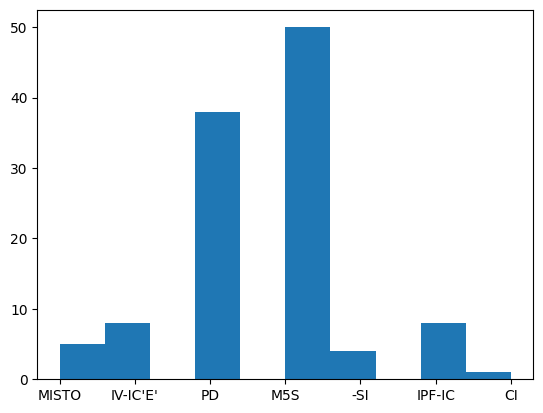

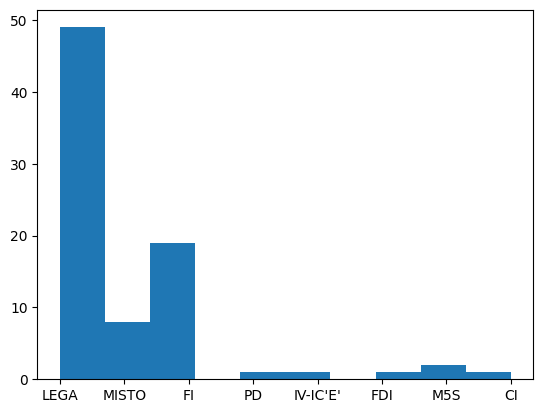

In [18]:
mm = 0
ms = 0
for nodes in cc.communities:
    mm += np.mean(df.iloc[nodes, -1])
    ms += np.std(df.iloc[nodes, -1])
    plt.hist(df.iloc[nodes, 2])
    plt.show()

In [19]:
ms/len(cc.communities)

0.10639683862088421

In [20]:
mm/len(cc.communities)

0.7079676042798386

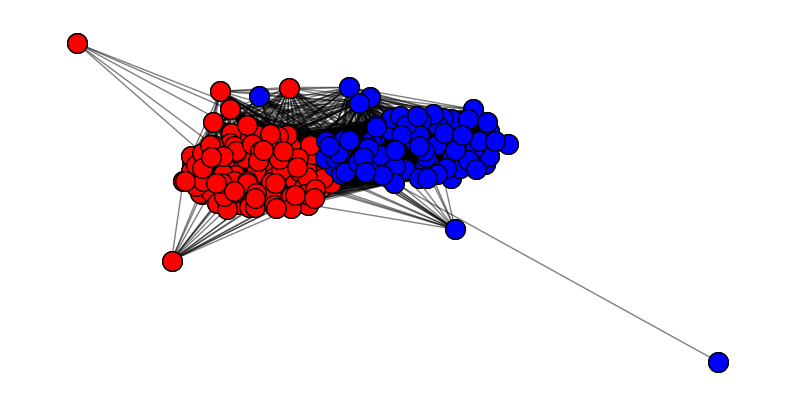

In [21]:
from cdlib import viz


pos = nx.spring_layout(G)
viz.plot_network_clusters(G, cc, pos, figsize=(10, 5), plot_labels=False, min_size=0)

### Demon/Angel

In [22]:
best = (-np.inf, 0)

for i in np.linspace(0,1, 15):
    comm = algorithms.angel(G, threshold= i, min_community_size= 5)
    bi = evaluation.newman_girvan_modularity(G, comm).score
    if bi > best[0]:
        print(bi, i)
        best = (bi, i)

0.01434949800741591 0.0
0.02727595926954588 1.0


In [23]:
best

(0.02727595926954588, 1.0)

In [24]:
comm = algorithms.angel(G, threshold= 0.07, min_community_size=5)

In [25]:
evaluation.newman_girvan_modularity(G, comm)

FitnessResult(min=None, max=None, score=0.01434949800741591, std=None)

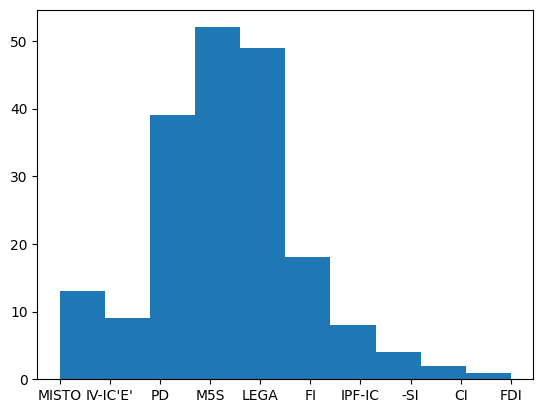

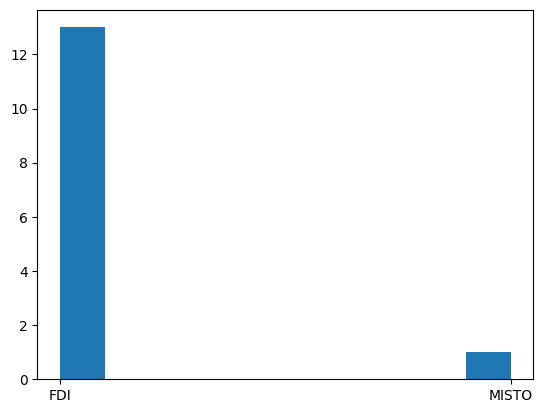

In [26]:
am = 0
ast = 0
for nodes in comm.communities:
    am += np.mean(df.iloc[nodes, -1])
    ast += np.std(df.iloc[nodes, -1])
    plt.hist(df.iloc[nodes, 2])
    plt.show()

In [27]:
am/len(comm.communities)

0.7088112940343424

In [28]:
ast/len(comm.communities)

0.09852473850040722

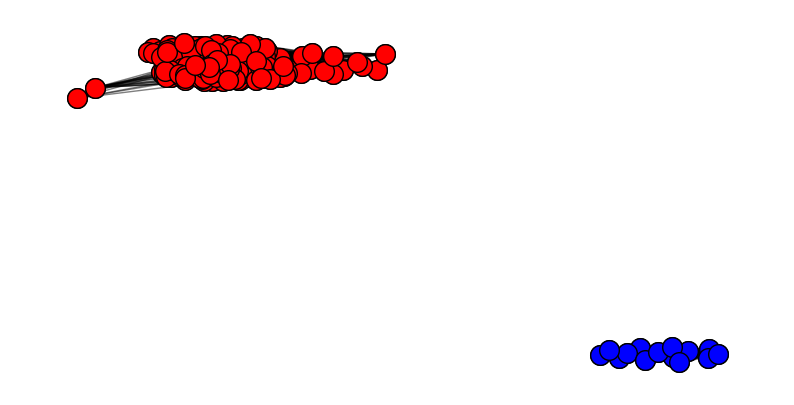

In [29]:
pos = nx.spring_layout(G)
viz.plot_network_clusters(G, comm, pos, figsize=(10, 5), plot_labels=False, min_size=5)

### k-clique

In [30]:
best = (-np.inf, 0)
for i in range(2,15):
    comm = algorithms.kclique(G, i)
    bi = evaluation.newman_girvan_modularity(G, comm).score
    if bi > best[0]:
        best = (bi, i)

In [ ]:
best

(0.009416682878488155, 11)

In [ ]:
comm = algorithms.kclique(G, best[1])

In [ ]:
evaluation.newman_girvan_modularity(G, comm)

FitnessResult(min=None, max=None, score=0.009416682878488155, std=None)

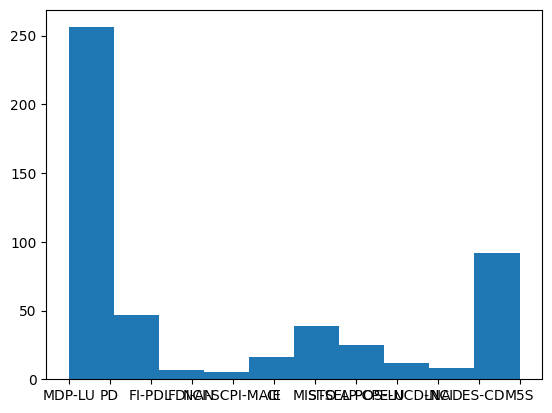

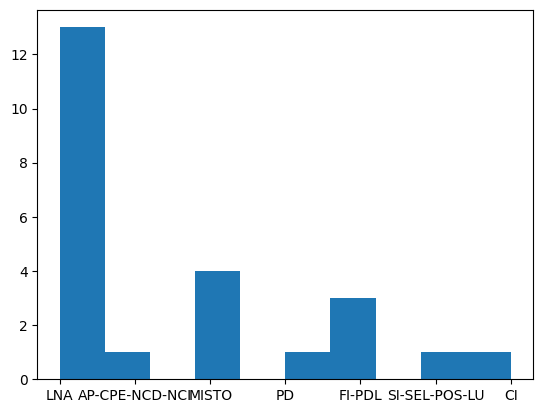

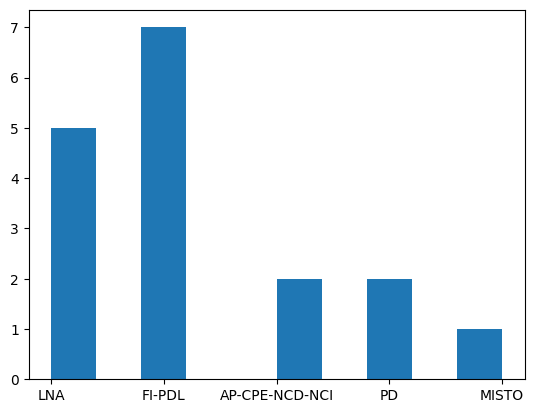

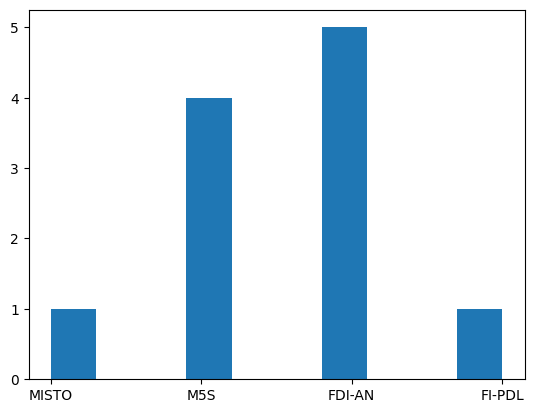

In [ ]:
am = 0
ast = 0
for nodes in comm.communities:
    am += np.mean(df.iloc[nodes, -1])
    ast += np.std(df.iloc[nodes, -1])
    plt.hist(df.iloc[nodes, 2])
    plt.show()

In [ ]:
am/len(comm.communities)

0.6706030018247212

In [ ]:
ast/len(comm.communities)

0.2443099817405084

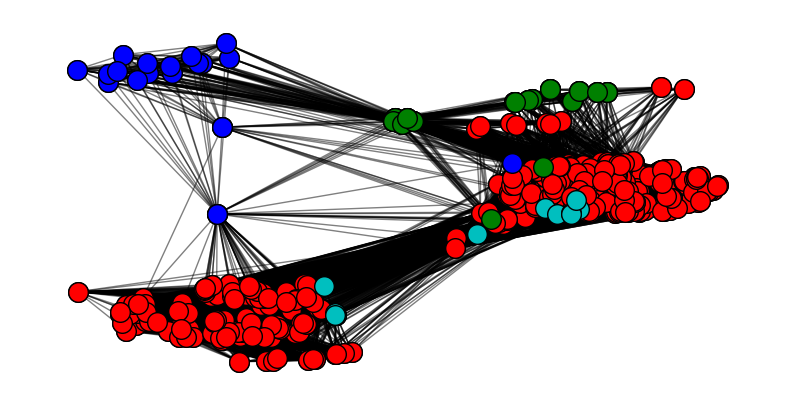

In [ ]:
pos = nx.spring_layout(G)
viz.plot_network_clusters(G, comm, pos, figsize=(10, 5), plot_labels=False, min_size=5)